## 决策树和集成学习

决策树：又称为分类和回归树(CART, Classification and Regression Tree)，能同时解决分类和回归问题。决策树可以理解为很多if-then-else规则的集合，代表数据之间的复杂交互，将新数据代入这些这些规则将得到分类或回归目标。

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## 1. 决策树

### 1.1 准备数据

IRIS数据集，根据花的四种特征，预测类别。

四个特征：

* sepalLength(花萼长度)
* sepalWidth(花萼宽度)
* petalLength(花瓣长度)
* petalWidth(花瓣宽度)

目标变量是花的类别：

* setosa(山鸢尾)
* versicolor(变色鸢尾)
* virginica(维吉尼亚鸢尾).

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target
iris_df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


### 1.2 拟合模型

In [3]:
# 拆分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=123)

# 创建决策树模型对象，使用默认参数，用基尼衡量不纯度
# 设置随机数种子，保证可重复结果
model = DecisionTreeClassifier(random_state=123)

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
acc = metrics.accuracy_score(y_test, y_pred)
print(f"accuracy score: {acc:.2f}")

accuracy score: 0.96


### 1.3 可视化决策树

从下图可以看出决策树模型的内在逻辑：

从根节点开始，选择一个特征，按照某种规则(如petal length <= 2.45)将样本拆分为两个部分，目标是尽可能完美的区分目标标量的标签，我们要纯度或不纯度来度量拆分的效果，如果节点对应的样本完全包含了某一个标签，不纯度为零，不需要进一步拆分节点，然而如果节点的不纯度很高，则需要制定新的规则进一步拆分。在这个案例中，当petal length <= 2.45时，样本数目是32个，仅包含1个标签，class=setosa，该节点的不纯度就是0，不需要进一步拆分。

重复上述的步骤，直到每一个节点的不纯度为0，不需要进一步拆分，该节点称为叶节点或终端节点。

In [4]:
from sklearn.tree import export_graphviz

In [5]:
with open("./datasets/tree.dot", "w") as file:
    export_graphviz(model, file, feature_names=iris.feature_names, class_names=iris.target_names)

![decision_tree](pictures/tree.png)

### 1.4 特征重要性

从上图可以看出，越靠近根节点的特征，越能够准确分类大量的样本，越靠近终端节点的特征，能够分类的样本数量越少。所以树模型还有一个重要的功能：计算特征重要度。

Text(0.5, 1.0, 'Feature Importance')

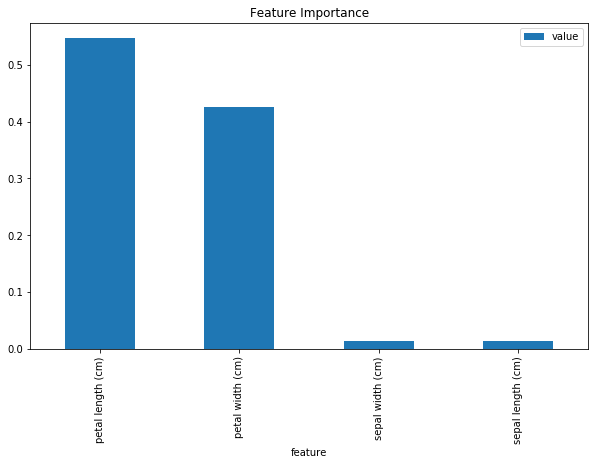

In [6]:
importances = pd.DataFrame({
    "feature": iris.feature_names,
    "value": model.feature_importances_
})
importances.sort_values("value", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))
importances.plot(x="feature", y="value", kind="bar", ax=ax)
ax.set_title("Feature Importance")

### 1.5 避免过度拟合

树模型的最大缺点是容易过度拟合，如果不加限制，树模型可能不断拆分直到每个节点对应一个观测值。可以调整核心参数，避免过拟合。

核心参数：

* max_depth: 树的最大深度。
* max_features: 拆分节点时考虑的最大特征数量，默认为考虑所有特征，当特征数量很多时，可以引入限制因子，仅考虑部分特征，提升分类效率。
    + max_features = k, 仅考虑k个特征
    + max_features = 'sqrt', 使用sqrt(n_features)
    + max_features = 'log2', 使用log2(n_features)
+ min_samples_split: 拆分节点时要求的最小样本数量，默认等于2，即如果节点的样本数量小于等于2，不再进行拆分。

**确定最优参数是困难的，使用网格搜索加K折交叉验证是最好的选择**

In [7]:
# 选择模型
estimator = DecisionTreeClassifier()

# 选择参数和扫描区间
param_grid = {
    "criterion": ["gini", "entropy"],  # 如何度量不纯度
    "max_depth": [5, 10, 15, None],  # 树的最大深度
    "max_features": ["sqrt", "log2", None],  # 拆分节点时考虑的最大特征数量
    "min_samples_split": [2, 5, 10, 20, 50]  # 拆分节点时要求的最小样本数量
}

# 网格搜索，寻找最优参数
grid = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring="accuracy",
    cv=5
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [8]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 20}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
0.9619047619047618


In [9]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(f"accuracy score: {acc:.2f}")

accuracy score: 0.93


## 2. 集成学习

集成学习：同时训练多个模型，基于这些模型预测结果的多数投票或平均值，生成分类和回归目标。

### 2.1 随机森林

随机模型(RandomForest)使用一组决策树，每棵树给出不同的预测，一般会基于多数投票给出最终预测，最多投票的类被认为是正确的。

sklearn的随机森林使用每棵树的平均结果给出最终预测，预测精度也非常高。

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
# 拆分训练集和检验集
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=123)

# 创建模型，使用10棵决策树
model = RandomForestClassifier(n_estimators=10)

# 拟合数据
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)

# 评估预测精度
acc = metrics.accuracy_score(y_test, y_pred)
print(f"accuracy score: {acc:.2f}")

accuracy score: 0.93


评估树的数量对预测精度的影响。

In [12]:
from sklearn.model_selection import cross_val_score

In [13]:
n_estimators_rng = list(range(1, 100))
acc_list = []

for n_estimators in n_estimators_rng:
    estimator = RandomForestClassifier(n_estimators)
    acc = cross_val_score(estimator, iris.data, iris.target,
                          scoring="accuracy", cv=10).mean()
    acc_list.append(acc)

Text(0.0, 1.0, 'Accuracy vs Estimators')

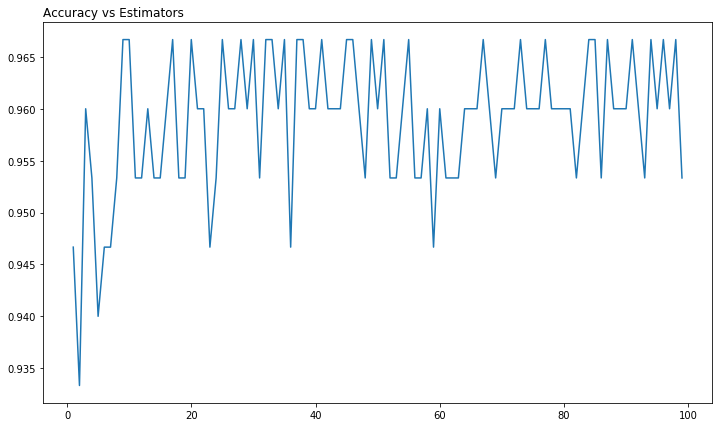

In [14]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(n_estimators_rng, acc_list)
ax.set_title("Accuracy vs Estimators", loc="left")

结果跟预期相符，当树的数量较少时，预测精度较低，但随着树数量增加，预测精度大幅上涨，当树数量大于20时，预测精度稳定在0.955-0.965.

随机森林模型也可以用于评估特征重要性。

In [15]:
from sklearn.datasets import make_classification

In [16]:
# 创建虚假数据集
X, y = make_classification(
    n_samples=1000,
    n_features=50,  # 50个特征
    n_informative=10,  # 10个重要特征
    n_redundant=40,  # 40个不重要特征
    n_classes=2  # 目标变量有2个类别
)

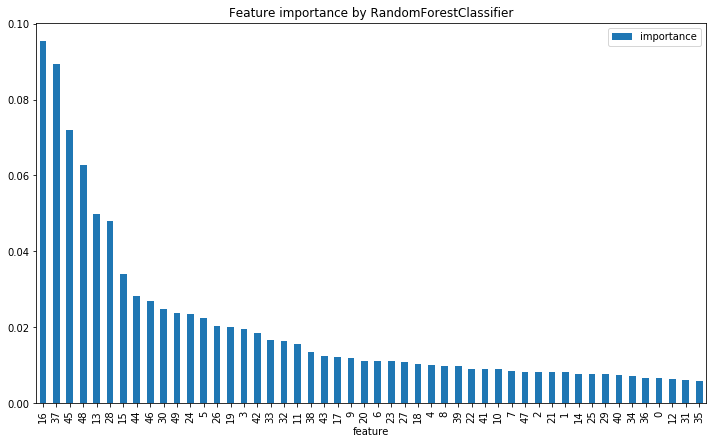

In [17]:
# 创建模型，拟合数据
model = RandomForestClassifier(n_estimators=100)
model.fit(X, y)

# 获取特征重要度
importances = pd.DataFrame({
    "feature": list(range(50)),
    "importance": model.feature_importances_
})
importances.sort_values("importance", ascending=False, inplace=True)

# 可视化
importances.plot(x="feature", y="importance", kind="bar", figsize=(12, 7),
                 title="Feature importance by RandomForestClassifier")

与预期相符，部分特征非常重要，部分特征没有意义。这在处理多维数据集时非常有用，使用决策树和随机森林评估特征重要度，并剔除重要性低于阈值的特征，减低数据集的维度。

### 2.2 AdaBoost

参考资料：

* [understanding AdaBoost](https://towardsdatascience.com/understanding-adaboost-2f94f22d5bfe)
* [sklearn - AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
* [adaboost ensemble in python](https://machinelearningmastery.com/adaboost-ensemble-in-python/)